## Title: Primer on Variational Inference and its application to Deep Learning

Abstract: Variational inference belongs to a class of statistical inference techniques and proved to be a workhorse in the area of generative modelling in machine learning community. In this primer we will cover some necessary theory to provide better understanding of this class of inference techniques. We will also discuss application of variational inference to Deep Learning, namely Variational Autoencoders (VAEs). Finally, some results from our research on de-novo design of metabolic enzymes, using VAEs, will be presented. 

# Primer on Variational inference
1. Very brief introduction
2. Kullback-Leibler divergence
3. Importance Sampling
4. Variational Inference
5. Mean-Field Variational Inference:
    - 5.1 Variational Inference applied to Gaussian Mixture Model
    - 5.2 Variational Inference applied to Ising Model

## 1. Very brief introduction
Probabilistic models is an alternative to more traditional deterministic models:
 - data is often noisy, non-stationary
 - we may want to incorporate our prior beliefs into the model

The **central** element of probabilistic models is **statistical inference**: any technique that we use to come up with estimates of probabilities incorporated into our model:
 - MLE
 - MAP
 - MCMC
 - Laplace Approximation
 - Variational Inference

If there is one formula that tells nearly everything about statistical inference (and the problems that arise with it), it is **Bayes rule**:
\begin{equation*}
  p(z|y) =\frac{p(y,z)}{p(y)} = \frac{p(y|z)p(z)}{p(y)} = \frac{p(y|z)p(z)}{\int p(y,z)dz}
\end{equation*}

We will aproach Variational Inference from different angles!


## 2. Kullback-Leibler divergence
Kullback-Leibler divergence $KL(p||q)$ defined as:

\begin{equation*}
  KL(p||q) = \int p(x) \log \frac{p(x)}{q(x)} dx = \mathbb{E}_{p(x)}[\log \frac{p(x)}{g(x)}]
\end{equation*}

$KL(p||q)$ measures the difference between two distributions $p$ and $q$ and has following properties:
- $KL(p||q) \geq 0$ (non-negative)
- $KL(p||q) = 0$ iff $p=q$
- $KL(p||q) \neq KL(q||p) $

Why KL is non-negative?
 - Use Jensen's inequality for concave functions: $\log \mathbb{E}[g(x)] \geq \mathbb{E}[\log g(x)]$
 - Proof:
     
     $\mathbb{E}_{p(x)}[\log \frac{q(x)}{p(x)}] \leq \log \mathbb{E}_{p(x)}[\frac{q(x)}{p(x)}] = \log \int p(x) \frac{q(x)}{p(x)} dx = \log \int q(x) dx = \log 1 = 0$.
     
   If $\mathbb{E}_{p(x)}[\log \frac{q(x)}{p(x)}] \leq 0$, then $\mathbb{E}_{p(x)}[\log \frac{p(x)}{q(x)}] \geq 0$.

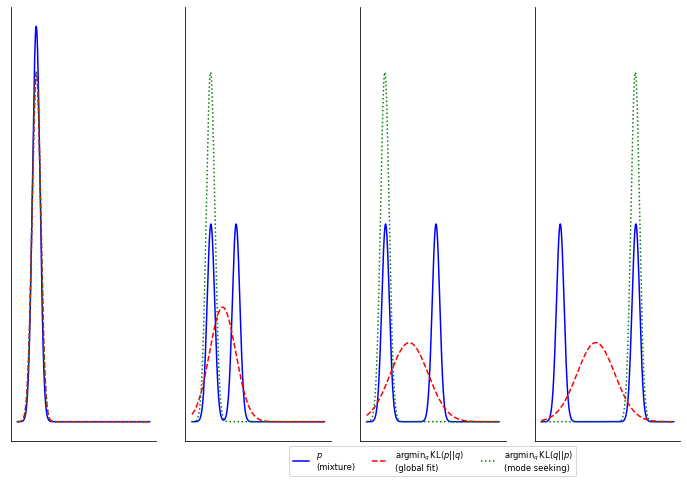

In [1]:
### credits to Tuan Anh Le
from KL_demo import KL_calculation_demo
KL_calculation_demo()

## 3. Importance Sampling
Estimate properties of a particular distribution, having samples from a different distribution (which is usually easy to sample from).
Let's assume problem of interest is estimating marginal likelihood:
\begin{equation*}
  p(y) = \int p(y,z)dz = \int p(y|z)p(z)dz
\end{equation*}
It may be difficult to do this integration, so Monte Carlo integration may be helpful. 
\begin{equation*}
  p(y) = \int p(y,z)dz = \int p(y|z)p(z)dz = \int p(y|z)p(z) \frac{q(z)}{q(z)}dz = \int p(y|z)\frac{p(z)}{q(z)}q(z)dz = \mathbb{E}_{q(z)}[p(y|z)\frac{p(z)}{q(z)}]
\end{equation*}
We can finally approximate the expectation with its MC estimate:
\begin{equation*}
  p(y) = \mathbb{E}_{q(z)}[p(y|z)\frac{p(z)}{q(z)}] \approx \frac{1}{N} \sum_{n=1}^{N} p(y|z^{n})\frac{p(z^{n})}{q(z^{n})}, z^{n} \sim q(z)
\end{equation*}

We have unbiased estimate but scales poorly to high-dimensional data.
We may want a technique that scales well to high-dimensional data and is **deterministic** (i.e. no sampling required). This technique is Variational Inference.


## 4. Variational Inference
Let's see how else we can try to solve the problem of estimating marginal likelihood.
Start the same as before, i.e:
\begin{equation*}
  p(y) = \mathbb{E}_{q(z)}[p(y|z)\frac{p(z)}{q(z)}] = \mathbb{E}_{q(z)}[\frac{p(y,z)}{q(z)}]
\end{equation*}
Instead of working with probability, let's work with log-probability:
\begin{equation*}
  \log p(y) = \log \mathbb{E}_{q(z)}[p(y|z)\frac{p(z)}{q(z)}] = \log \mathbb{E}_{q(z)}[\frac{p(y,z)}{q(z)}]
\end{equation*}
By appplying concavity (see Jensen's inequality) of the logarithm, we get:
\begin{equation*}
  \log p(y) = \log \mathbb{E}_{q(z)}[\frac{p(y,z)}{q(z)}] \geq \mathbb{E}_{q(z)}[\log \frac{p(y,z)}{q(z)}]
\end{equation*}
Now let's take a closer look at the expected value of the logarith (of some function):
\begin{equation*}
  \mathbb{E}_{q(z)}[\log \frac{p(y,z)}{q(z)}] = \mathbb{E}_{q(z)}[\log p(y|z)] - KL(q(z)||p(z))
\end{equation*}
Finally, we get the following (most important equation):
\begin{equation*}
  \log p(y) \geq \mathbb{E}_{q(z)}[\log p(y|z)] - KL(q(z)||p(z)) = \mathbb{F}(y,q)
\end{equation*}

We want to maximize $\mathbb{F}(y,q)$ to have our lower bound as close as possible to data log-likelihood (also called model evidence).

Few important notes about $\mathbb{F}(y,q)$:
1. KL-term ($KL(q(z)||p(z))$) is a "mode-seeking" KL-divergence (see note about KL-divergence).
2. The whole thing is called **Variational Free Energy**. The term **variational** comes from the fact that we want to maximize it w.r.t to a function $q(z)$.
3. Distribution $q(z)$ really depends on a data (i.e. $q(z|y)$), which makes it **variational posterior distribution** (true posterior is $p(z|y)$).

What have we achieved?
1. Integration is now optimisation: we optimize for $q(z)$. We will talk more about this!
2. Easy convergence criteria: check when $\mathbb{F}(y,q)$ stops changing.

It may be useful to distinguish between **Variational Inference (VI)** and **Variational Bayesian Inference (VB)**.
If we have a generative model $p(y|z,\theta)p(z|\theta)$ where $\theta$ are some parameters (i.e. weights in NN), then distinction is following:
1. In **VI**, we approximate only distribution of latent variable $q(z|y)$ and learn parameters $\theta$ by MLE. Example: Variational Autoencoder.
2. In **VB**, we approximate both latent variables and parameters with some variational distribution $q(z,\theta|y)$.

## 5. Mean-field Variational Inference

Here, we present an example on applying Variational Inference to Gaussian Mixture Model.
But first, let's dive into **Mean-Field Variational Inference** and **CAVI (Coordinate Ascent Variational Inference)**.

**Mean-field approximation** means the **factorization** of variational distribution:
\begin{equation*}
  q(z) = q(z_1 \cdots z_m) = \prod_{j=1}^{m} q(z_j)
\end{equation*}

**CAVI** means: fix all but one parameter, update that one parameter.

Let's see how mean-field and CAVI come into play when we want to maximize $\mathbb{F}(y,q)$.

Let's try to derive update equations in a generic form:
1. We notice that $\mathbb{F}(y,q) = \mathbb{E}_{q(z)}[\log p(y|z)] - KL(q(z)||p(z)) = \mathbb{E}_{q(z)}[\log p(y,z)] - \mathbb{E}_{q(z)}[\log q(z)]$. The last term ($\mathbb{E}_{q(z)}[\log q(z)]$) is called an entropy term, denoted $\mathbb{H}({q(z)})$.
2. We rewrite the first term as follows: $\mathbb{E}_{q(z)}[\log p(y,z)] = \mathbb{E}_{q(z)}[\log p(y,z_{-j},z_{j})]$, where $z_{-j} = (z_1,z_2 \cdots z_{j-1},z_{j+1} \cdots)$.
3. Because of **mean-field** assumption, the second term can be written in the following way: $\mathbb{E}_{q(z)}[\log q(z)] = \sum_{j=1}^{K} \mathbb{E}_{q(z_j)}[\log q(z_j)]$.
4. Finally, combining all above we ge the following result:
\begin{equation*}
  \mathbb{F}(y,q) = \mathbb{E}_{q(z)}[\log p(y,z)] - \mathbb{E}_{q(z)}[\log q(z)] = \mathbb{E}_{q(z)}[\log p(y,z_{-j},z_{j})] - \sum_{j=1}^{K} \mathbb{E}_{q(z_j)}[\log q(z_j)]
\end{equation*}
5. Since we are doing **CAVI**, we need to isolate terms related to $z_j$, so we continue manipulating previous equation using law of total expectation $\mathbb{E}(X) = \mathbb{E}(\mathbb{E}(X|Y))$:
\begin{equation*}
  \mathbb{F}(y,q) = \mathbb{E}_{q(z)}[\log p(y,z_{-j},z_{j})] - \sum_{j=1}^{K} \mathbb{E}_{q(z_j)}[\log q(z_j)] = \mathbb{E}_{q(z_j)}[\mathbb{E}_{q(z_{-j})}[\log p(y,z_{-j},z_{j})]|z_j] - \mathbb{E}_{q(z_j)}[\log q(z_j)] + const
\end{equation*}
6. Again, because we have **mean-field** assumption ,we can simply the term with conditional expectation:
\begin{equation*}
    \mathbb{E}_{q(z_{-j})}[\log p(y,z_{-j},z_{j})]|z_j] = \int \log p(y,z_{-j},z_{j}) q(z_{-j}|z_j) = \int \log p(y,z_{-j},z_{j}) q(z_{-j}) = \mathbb{E}_{q(z_{-j})}[\log p(y,z)]
\end{equation*}
7. Finally, putting all together:
\begin{equation*}
    \mathbb{F}(y,q_j,q_{-j}) = \mathbb{E}_{q(z_{j})}[\mathbb{E}_{q(z_{-j})}[\log p(y,z)]] - \mathbb{E}_{q(z_j)}[\log q(z_j)] + const
\end{equation*}
8. We want to maximize this $\mathbb{F}$ (see 7) w.r.t $q(z_j)$ ($q(z_{-j})$ is fixed). There are two ways to do so. One way involves differentiating $\mathbb{F}$ w.r.t $q(z_j)$, which is a function, so we need to apply functional derivative. We will not go this route but a reference to variational calculus will be provided. Another way is adopted from K.Murphy's ML:A probabilistic Perspective.
    - Notice that you can combine terms under $\mathbb{E}_{q(z_{j})}$ to form a negative KL term: $\mathbb{E}_{q(z_{j})}[\mathbb{E}_{q(z_{-j})}[\log p(y,z)]] - \mathbb{E}_{q(z_j)}[\log q(z_j)] = -KL(q(z_{j})||\exp(\mathbb{E}_{q(z_{-j})}[\log p(y,z)]))$. 
    - Since KL is non-negative, we **maximize it by setting $q(z_{j}) \propto \exp(\mathbb{E}_{q(z_{-j})}[\log p(y,z)])$**. Proportionality comes from the fact that normalisation constant is needed to be sure that it is a valid distribution.

## 5.1 Variational Inference applied to Gaussian Mixture Models
Now that we know how update equations are derived in general, we can look at particular case. 
We have a Gaussian Mixture Model with K components:
\begin{align*}
\mu_{j} \sim N(0,\sigma^2) \text{,for j=1...K} \\
c_i \sim Categorical(\frac{1}{K} \cdots \frac{1}{K}) \text{,for i=1...N} \\
x_i|c_i,\mu \sim N(c^{T}\mu,1) \text{,for i=1...N}
\end{align*}
The data likelihood (which is computationally intractable) looks the following:
\begin{equation*}
  p(x) = \sum_{c} p(c) \int p(\mu) \prod_{i=1}^{N} p(x_i|c_i,\mu)d\mu
\end{equation*}



What exactly are we approximating and how? 
1. $q(\mu_j;m_j,s_j^2)$ = $N(\mu_j;m_j,s_j^2)$, a normal distribution with mean $m_j$ and variance $s_j^2$.
2. $q(c_i;\phi_i)$ = Categorical($\phi_i$), a categorical distribution with probability vector $\phi_i$. This means that probability of assigning i-th obsevation to cluster $j$ is $\phi_{ij}$. Formally: $P(c_i = j) = \phi_{ij}$.

Ok, how do we do optimisation?
1. We will do **CAVI (Coordinate Ascent Variational Inference)**: fix all but one parameter, update that one parameter.
2. Parameters are: $m_j$,$s_j^2$ and $\phi_i$. Note that $\sum_j \phi_{ij}=1$. Update equations need to be derived for this parameters.

We won't derive equations here as it is time consuming. Here are the end results:
1. $\phi_{ij}^{*} \propto  \exp(-\frac{1}{2}(m_j^{2} + s_j^{2} + x_i m_j)$. Normalisation is straighforward.
2. $m_j^{*} = \frac{\sum_i \phi_{ij}x_i}{\frac{1}{\sigma^2} + \sum_i \phi_{ij}}$.
3. $s_{j}^{2*} = \frac{1}{\frac{1}{\sigma^2} + \sum_i \phi_{ij}}$.
4. ELBO = $\sum_i \sum_j \phi_{ij}[-\frac{x_i^{2}}{2} + m_j x_i - \frac{m_j^{2} + s_j^{2}}{2}] + \sum_i \sum_j \phi_{ij}\log \phi_{ij} + \sum_j \frac{-\log s_j^{2}}{2} + \sum_j \frac{-(m_j^{2} + s_j^{2})}{2\sigma^2}$ (Really, should be **proportional to**, not **equal to**).



Finally, **very** useful links:
1. Variational calculus introduction: https://bjlkeng.github.io/posts/the-calculus-of-variations/
2. Variational inference example for GMM: https://zhiyzuo.github.io/VI/
3. VI: Review for statisticians: https://arxiv.org/pdf/1601.00670.pdf

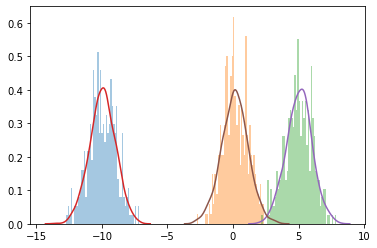

In [1]:
### credits to Tony Chen
from VI_GMM_demo_pytorch import VI_GMM_demo
VI_GMM_demo()

## 5.2 Variational Inference applied to Ising Model
Here, we will discuss how VI can be applied to Ising model, which is a canonical Markov Random Field (MRF) or undirected graphical model.

<figure>
    <img src="figures/Ising-model.png" width=300 height=300 title="Ising Model"/>
    <div style='width: 280; text-align: center;'>Ising Model</div>
</figure>

Let's quickly discuss what is what:
1. $x$ - hidden pixel values of "clean" image with distribution.
2. $y$ - noisy observations, what we really observe.

Let's describe distributions and a joint model:
\begin{align*}
p(x) = \frac{1}{Z_0} \exp(\sum_{i=1}^{D}\sum_{j \in Nbr(i)} x_i w_{ij} x_j) = \frac{1}{Z_0} \exp(\sum_{i,j \in E} x_i w_{ij} x_j) \\
p(y_i|x_i) = L(x_i) = N(y_i|x_i,\sigma^2)
\end{align*}

We are interested in "clean", denoised image, which means we are interested in $p(x|y)$. Unfortunately, true posterior is hard to compute (as we need to do summations of order $2^{D}$ to compute normalisation constant). We will use variational inference instead. 

Our variational distribution $q(x)$ will follow mean-field assumption: $q(x) = \prod_{i=1}^{D}q_i(x_i)$.
Each $q_i(x_i)$ is Bernoulli-like random variable: it takes value $+1$ with probability $q_i(x_i=+1)$ and value $-1$ with probability $q_i(x_i=-1)$. We are interested in its mean value, which we denote by $\mu_i$.

We can use a recipe, which we developed previously, namely: $q_i(x_i) \propto \exp(\mathbb{E}_{q(x_{-j})}[\log p(y,x)])$. Once some algebra is used (and $w_{ij}$ is fixed as $J$ for all $i,j$), we arrive at (almost) final form:
\begin{equation*}
  q_i(x_i) \propto \exp(x_i \sum_{j \in Nbr(i)} J\mu_j + \log N(y_i|x_i,\sigma^2))
\end{equation*}

Since $q_i(x_i$) is binary random variable, it is relatively straighforward to compute $q_i(x_i = +1)$ and $q_i(x_i = -1)$. You can consult K.Murphy or just use the equations below ($\sigma(x)$ is sigmoid function):
\begin{align*}
m_i = \sum_{j \in Nbr(i)} J \mu_{j} \\
L_{i}^{+} = \log N(y_i|x_i=+1,\sigma^2) \\
L_{i}^{-} = \log N(y_i|x_i=-1,\sigma^2) \\
a_i = m_i +0.5(L_{i}^{+} - L_{i}^{-}) \\
q_i(x_i=+1) = \sigma(2a_i) \\
q_i(x_i=-1) = \sigma(-2a_i) \\
mu_i = tanh(a_i)
\end{align*}

The ELBO will take the following form:
$ELBO = \mathbb{E_{q(x)}}[\log p(y,x)] - \mathbb{E_{q(x)}}[\log q(x)] = \mathbb{E_{q(x)}}[\sum_{i,j \in E} x_i J x_j + \sum_{i=1}^{D} \log N(y_i|x_i,\sigma^2)] - \sum_{i=1}^{D}\mathbb{E_{q_i(x_i)}}[\log q_i(x_i)]$


  0%|          | 0/30 [00:00<?, ?it/s]

Size of image: 310-by-419


100%|██████████| 30/30 [04:51<00:00,  9.71s/it]


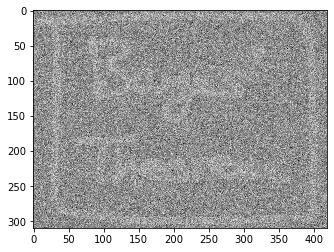

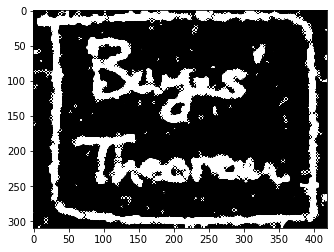

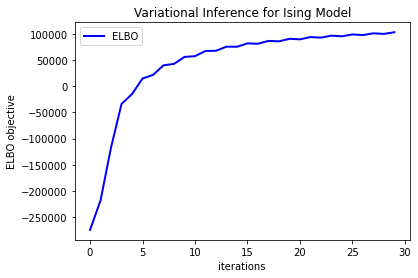

In [2]:
### lets try VI on Ising Model: inspired by Vadim Smolyakov
from VI_Ising_Model_demo import VI_Ising_Model_demo

VI_Ising_Model_demo(noise_level=3.5,J=1.0,n_iter=30)